# Processing of the BEAM-T sample data from Cellranger

Data was downloaded and processed as described here:
- https://www.10xgenomics.com/datasets/5k-human-a0201-b0702-pbmcs-beam-t-2-standard
- https://www.10xgenomics.com/datasets/10k-human-a1101-pbmcs-with-ebv-spike-in-beam-t-2-standard
- https://www.10xgenomics.com/datasets/10k-human-a2402-pbmcs-with-ebv-and-cmv-spike-in-beam-t-2-standard
- https://www.10xgenomics.com/datasets/10k-human-a0201-pbmcs-with-cmv-flu-and-sars-cov2-spike-in-beam-t-2-standard


In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

import scanpy as sc
import scirpy as ir
import anndata as ann

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sc.set_figure_params(vector_friendly=True, color_map='viridis', transparent=True)
sb.set_style('whitegrid')
#sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

## Settings

In [3]:
path_base = '../data/raw/BEAM-T'
path_merged = f'{path_base}/01_beam-t_merged.h5ad'

## Join the data

In [4]:
adatas = []
adatas_vdj = []

samples = ['10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein', 
           '10k_BEAM-T_Human_A1101_EBV_spikein', 
           '10k_BEAM-T_Human_A2402_EBV_CMV_spikein',
           '5k_BEAM-T_Human_A0201_B0702_PBMC']
for sample in samples:
    # GEX data
    path_gex = f'{path_base}/{sample}/sample_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(path_gex, gex_only=False)
    adata_tmp.var_names_make_unique()

    # VDJ data
    path_vdj = f'{path_base}/{sample}/filtered_contig_annotations.csv'
    adata_vdj_tmp = ir.io.read_10x_vdj(path_vdj)
    ir.pp.merge_with_ir(adata_tmp, adata_vdj_tmp)
    
    # Antigen data
    path_antigen = f'{path_base}/{sample}/antigen_specificity_scores.csv'
    df_antigen_tmp = pd.read_csv(path_antigen)#, index_col=0)
    df_antigen_tmp = df_antigen_tmp.pivot(index='barcode', 
                                          columns=['antigen', 'mhc_allele'], 
                                          values=['antigen_umi', 'antigen_specificity_score'])
    df_antigen_tmp.columns = [f'{s[8:]}_{e}_{mhc}' for s, e, mhc in df_antigen_tmp.columns]
    adata_tmp.obs = adata_tmp.obs.join(df_antigen_tmp)
    adatas.append(adata_tmp)
    
adata = adatas[0].concatenate(adatas[1:], batch_key='sample', batch_categories=samples)
adata.shape

reading ../data/raw/BEAM-T/10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein/sample_filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading ../data/raw/BEAM-T/10k_BEAM-T_Human_A1101_EBV_spikein/sample_filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../data/raw/BEAM-T/10k_BEAM-T_Human_A2402_EBV_CMV_spikein/sample_filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../data/raw/BEAM-T/5k_BEAM-T_Human_A0201_B0702_PBMC/sample_filtered_feature_bc_matrix.h5
 (0:00:00)


(32519, 36601)

## Quality Control

Basic analysis by amount counts, genes, and fraction of mitochondrial genes

adata.obs['n_counts'] = adata.X.A.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X.A > 0).sum(axis=1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_idx = np.where(mt_gene_mask)[0]
adata.obs['mt_frac'] = adata.X.A[:, mt_gene_idx].sum(1) / adata.X.A.sum(axis=1)

print('Mean # Genes: ', adata.obs['n_genes'].mean())
print('Median # Genes: ', adata.obs['n_genes'].median())
print('Mean # Counts: ', adata.obs['n_counts'].mean())
print('Median # Counts: ', adata.obs['n_counts'].median())
print('Mean % MT: ', adata.obs['mt_frac'].mean())
print('Median % MT: ', adata.obs['mt_frac'].median())

rcParams['figure.figsize'] = (16, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90, groupby='sample')

qc_groups = [
    '10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein', 
    '10k_BEAM-T_Human_A1101_EBV_spikein', 
    '10k_BEAM-T_Human_A2402_EBV_CMV_spikein',
    '5k_BEAM-T_Human_A0201_B0702_PBMC'    
]

rcParams['figure.figsize'] = (8, 8)
for g in qc_groups:
    print(g)
    adata_tmp = adata[adata.obs['sample']==g]
    sc.pl.scatter(adata_tmp, y='n_genes', x='n_counts', color ='mt_frac', size=10, show=False)
    sc.pl.scatter(adata_tmp[np.logical_and(adata_tmp.obs['n_genes']<1500, adata_tmp.obs['n_counts']<8000)],
             y='n_genes', x='n_counts', color='mt_frac', size=10, show=False)
    plt.show()

### Apply Filtering

params_filter = [
    {   'mt_frac': 0.15,
        'n_counts_min': 1400,
        'n_counts_max': 12000,
        'n_genes_min': 800,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1200,
        'n_counts_max': 13000,
        'n_genes_min': 700,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1500,
        'n_counts_max': 15000,
        'n_genes_min': 700,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1200,
        'n_counts_max': 10000,
        'n_genes_min': 800,
    },    
]

adatas = []

for i, g in enumerate(qc_groups):
    adata_tmp = adata[adata.obs['sample']== g]
    params = params_filter[i]
    
    print(f'Size of Group {i} before filtering: {len(adata_tmp)}')
    adata_tmp = adata_tmp[adata_tmp.obs['mt_frac'] < params['mt_frac']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_counts'] > params['n_counts_min']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_counts'] < params['n_counts_max']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_genes'] > params['n_genes_min']]
    print(f'Size of Group {i} after filtering: {len(adata_tmp)}')
    print('')
    adatas.append(adata_tmp)
    
adata = adatas[0].concatenate(adatas[1:])
sc.pp.filter_genes(adata, min_cells=10)
adata.shape

## QC after filtering

rcParams['figure.figsize'] = (16, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90, groupby='sample')

## TCR stats

In [5]:
ir.tl.chain_pairing(adata)
adata.obs['chain_pairing'].value_counts()

single pair        14151
no IR              13371
orphan VDJ          2797
extra VJ            1534
orphan VJ            277
extra VDJ            252
two full chains      137
Name: chain_pairing, dtype: int64

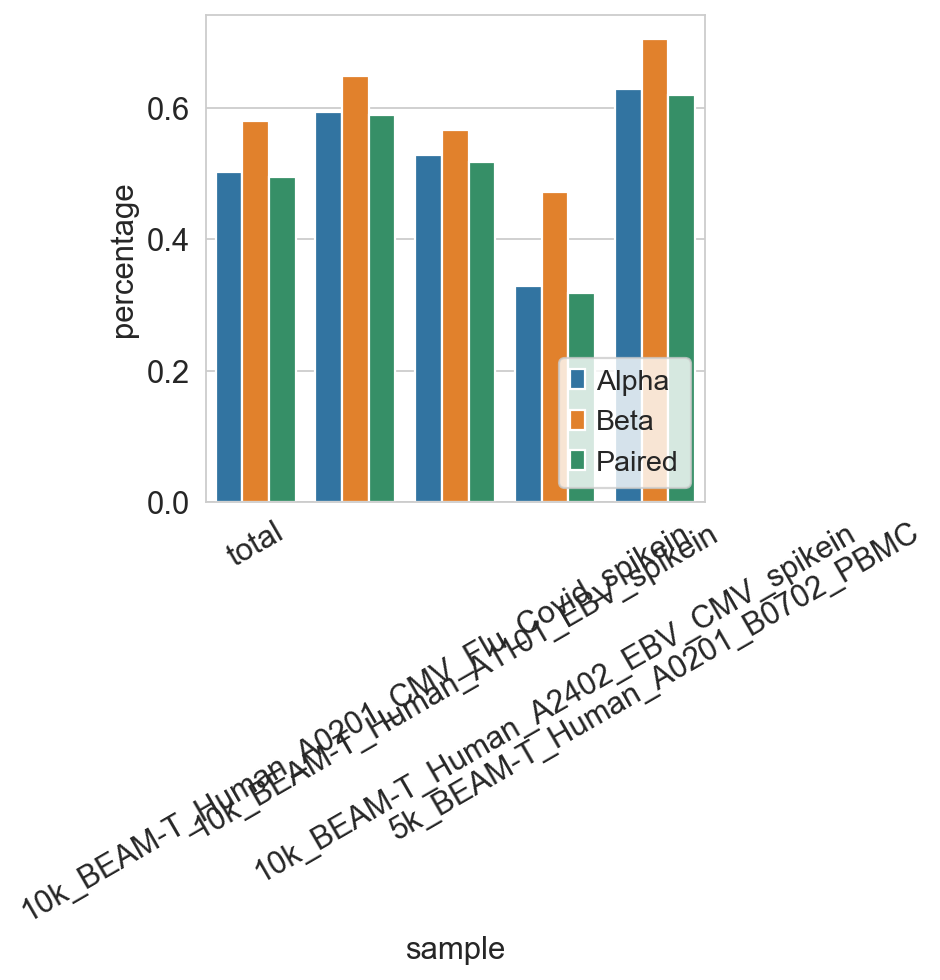

In [6]:
def get_percentages_tcr(data):
    p_alpha = data.obs['IR_VJ_1_junction_aa'].notnull().mean()
    p_beta = data.obs['IR_VDJ_1_junction_aa'].notnull().mean()
    p_paired = (data.obs['IR_VDJ_1_junction_aa'].notnull() & data.obs['IR_VJ_1_junction_aa'].notnull()).mean()
    return [p_alpha, p_beta, p_paired]

samples = ['total'] * 3
chains = ['Alpha', 'Beta', 'Paired'] * 5
percentages = get_percentages_tcr(adata)

for sample in adata.obs['sample'].unique():
    adata_tmp = adata[adata.obs['sample']==sample]
    percentages += get_percentages_tcr(adata_tmp)
    samples += [sample] * 3

df_tcr_fractions = {
    'sample': samples,
    'chain': chains,
    'percentage': percentages
}
df_tcr_fractions = pd.DataFrame(df_tcr_fractions)
g = sb.barplot(data=df_tcr_fractions, y='percentage', x='sample', hue='chain')
g.set_xticklabels(rotation=30, labels=g.get_xticklabels())
plt.legend(loc='lower right')

<AxesSubplot:title={'center':'Fraction of chain_pairing in each sample'}, xlabel='sample', ylabel='Fraction of cells in chain_pairing'>

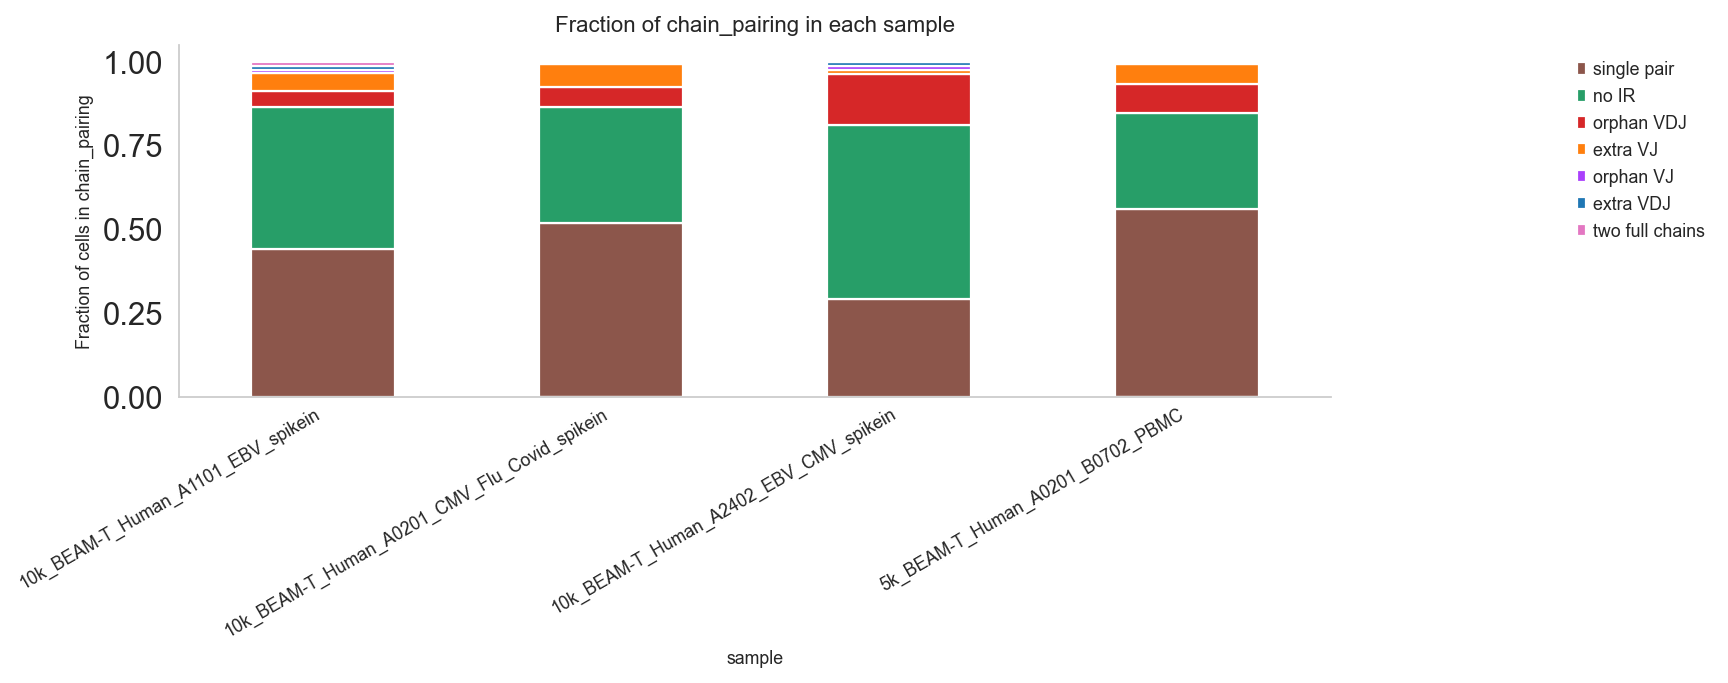

In [7]:
ir.tl.chain_pairing(adata)
ir.pl.group_abundance(adata, groupby='sample', target_col='chain_pairing', normalize=True, fig_kws={'figsize': (12, 4)})

In [8]:
adata.obs['chain_pairing'].value_counts()

single pair        14151
no IR              13371
orphan VDJ          2797
extra VJ            1534
orphan VJ            277
extra VDJ            252
two full chains      137
Name: chain_pairing, dtype: int64

In [9]:
print(f'Full adata: {len(adata)}')
adata = adata[adata.obs['chain_pairing'].isin(['single pair', 'extra VJ', 'extra VDJ', 'two full chains'])]
print(f'TCR adata: {len(adata)}')

Full adata: 32519
TCR adata: 16074


## Assign specificity

In [10]:
epitag_2_epitope = {
    'CMV_HLA-A*02:01': 'NLVPMVATV_HLA-A*02:01',
    'EBV_BMLF-1_GLCT_HLA-A*02:01': 'GLCTLVAML_HLA-A*02:01', 
    'EBV_BRLF1_YVLD_HLA-A*02:01': 'YVLDHLIVV_HLA-A*02:01',
    'Flu_HLA-A*02:01': 'GILGFVFTL_HLA-A*02:01', 
    'SARS_Cov2_HLA-A*02:01': 'KLPDDFTGCV_HLA-A*02:01',
    'CMV_HLA-A*11:01': 'NLVPMVATV_HLA-A*11:01',
    'EBV_HLA-A*11:01': 'AVFDRKSDAK_HLA-A*11:01',
    'CMV_HLA-A*24:02': 'AYAQKIFKI_HLA-A*24:02',
    'EBV_HLA-A*24:02': 'TYGPVFMCL_HLA-A*24:02',
    'CMV_B0702_HLA-B*07:02': 'TPRVTGGGAM_HLA-B*07:02',
    'Flu_A0201_HLA-A*02:01': 'GILGFVFTL_HLA-A*02:01',
}

In [11]:
scores = [f'specificity_score_{v}' for v in epitag_2_epitope]
counts = [f'umi_{v}' for v in epitag_2_epitope]

In [12]:
adata.obs['max_score'] = np.nanmax(adata.obs[scores].values, axis=1)
adata.obs['max_count'] = np.nanmax(adata.obs[counts].values, axis=1)
adata.obs['max_epitope'] = np.nanargmax(adata.obs[scores].values, axis=1)
adata.obs['max_epitope'] = adata.obs['max_epitope'].apply(lambda x: scores[x].split('_score_')[1])
adata.obs['max_epitope'] = adata.obs['max_epitope'].map(epitag_2_epitope)
adata.obs['max_epitope'].value_counts()

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


NLVPMVATV_HLA-A*02:01     3794
GILGFVFTL_HLA-A*02:01     3509
AVFDRKSDAK_HLA-A*11:01    2709
NLVPMVATV_HLA-A*11:01     2369
TYGPVFMCL_HLA-A*24:02     1769
AYAQKIFKI_HLA-A*24:02     1178
KLPDDFTGCV_HLA-A*02:01     547
TPRVTGGGAM_HLA-B*07:02     190
YVLDHLIVV_HLA-A*02:01        7
GLCTLVAML_HLA-A*02:01        2
Name: max_epitope, dtype: int64

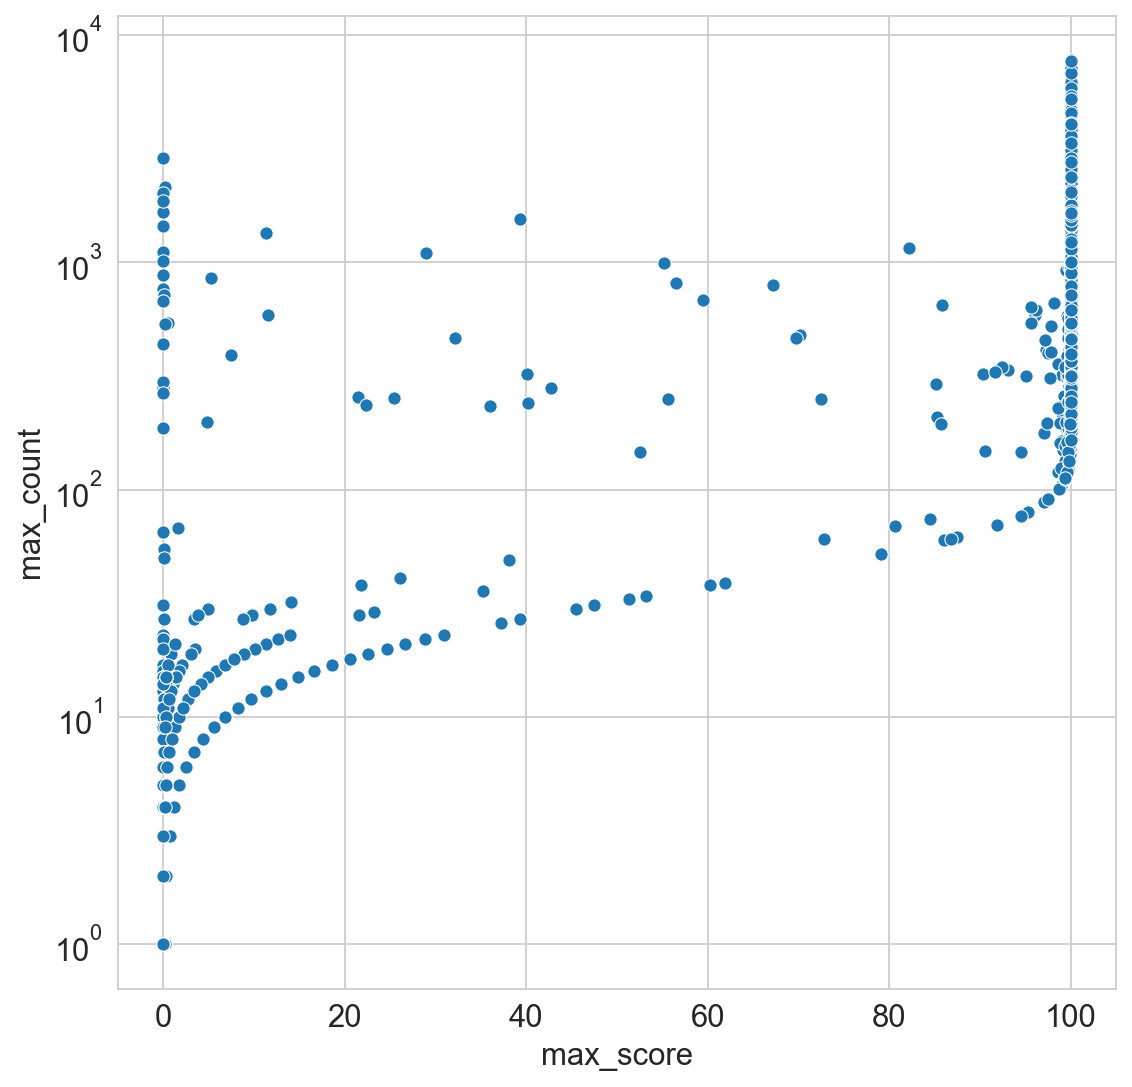

In [13]:
rcParams['figure.figsize'] = (8, 8)
plot = sb.scatterplot(data=adata.obs, x='max_score', y='max_count')
plot.set_yscale('log')

(0.0, 200.0)

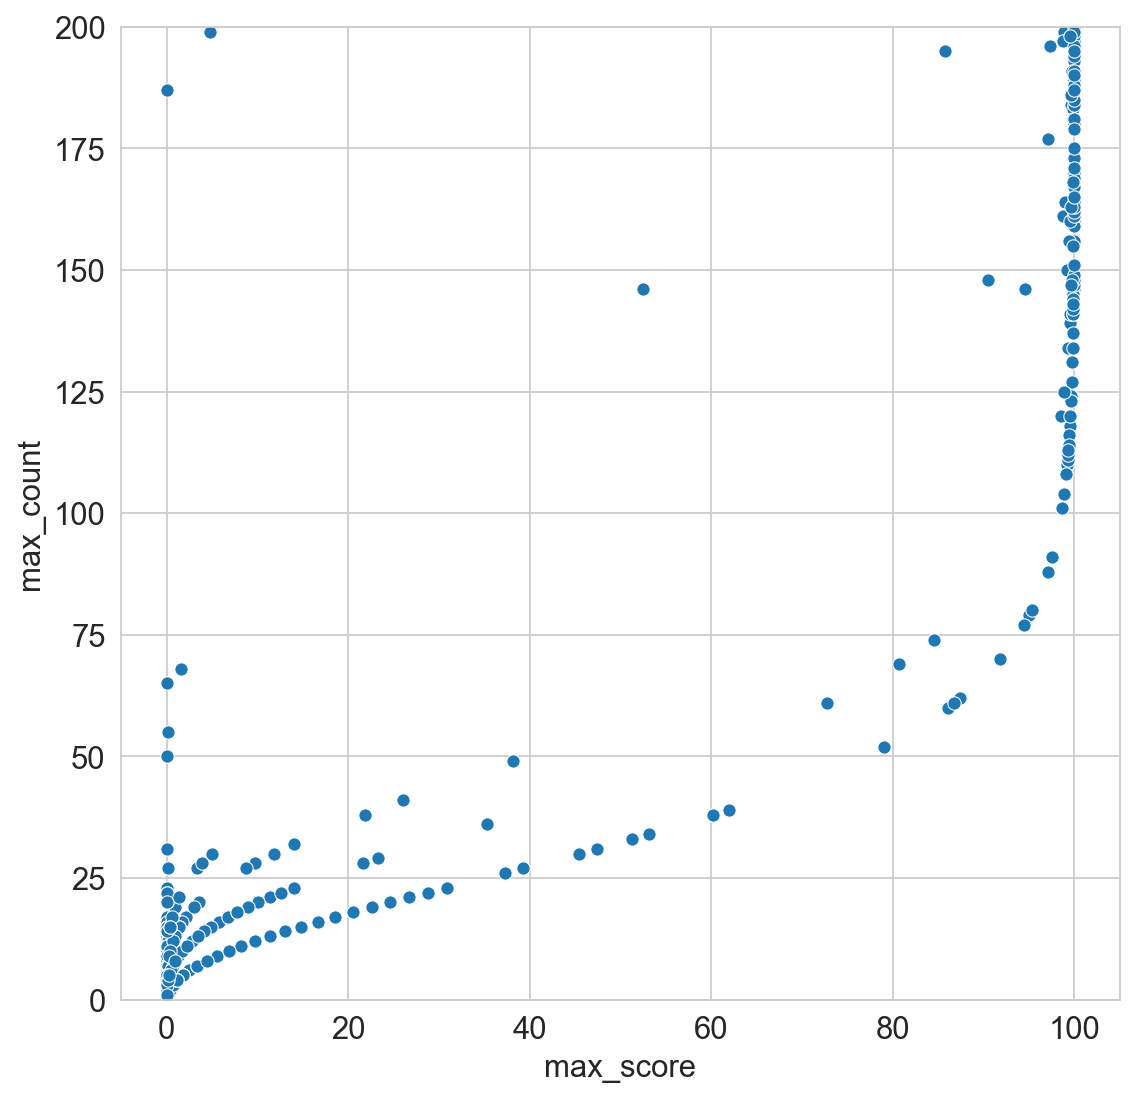

In [14]:
plot = sb.scatterplot(data=adata.obs, x='max_score', y='max_count')
plot.set_ylim((0, 200))

### Filter low binder

<AxesSubplot:xlabel='max_score', ylabel='Count'>

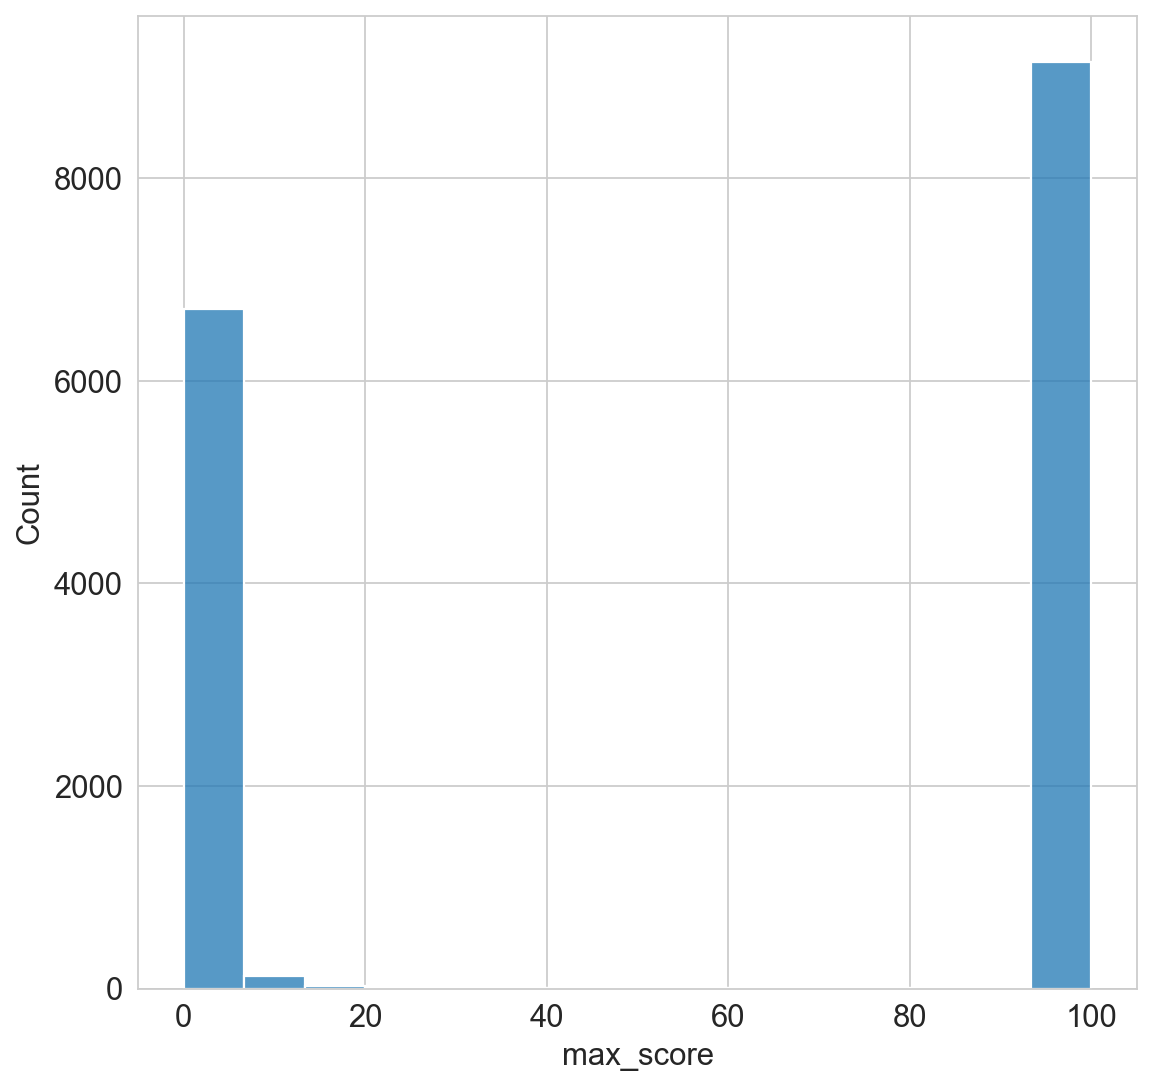

In [15]:
sb.histplot(adata.obs['max_score'])

In [16]:
print(f'All binders: {len(adata)}')
adata = adata[adata.obs['max_score']>=92.5]
print(f'High binders: {len(adata)}')
adata.obs['max_epitope'].value_counts()

All binders: 16074
High binders: 9148


NLVPMVATV_HLA-A*02:01     3761
GILGFVFTL_HLA-A*02:01     3491
TYGPVFMCL_HLA-A*24:02      558
KLPDDFTGCV_HLA-A*02:01     545
AVFDRKSDAK_HLA-A*11:01     360
AYAQKIFKI_HLA-A*24:02      243
TPRVTGGGAM_HLA-B*07:02     181
YVLDHLIVV_HLA-A*02:01        7
GLCTLVAML_HLA-A*02:01        2
Name: max_epitope, dtype: int64

<AxesSubplot:xlabel='max_score', ylabel='Count'>

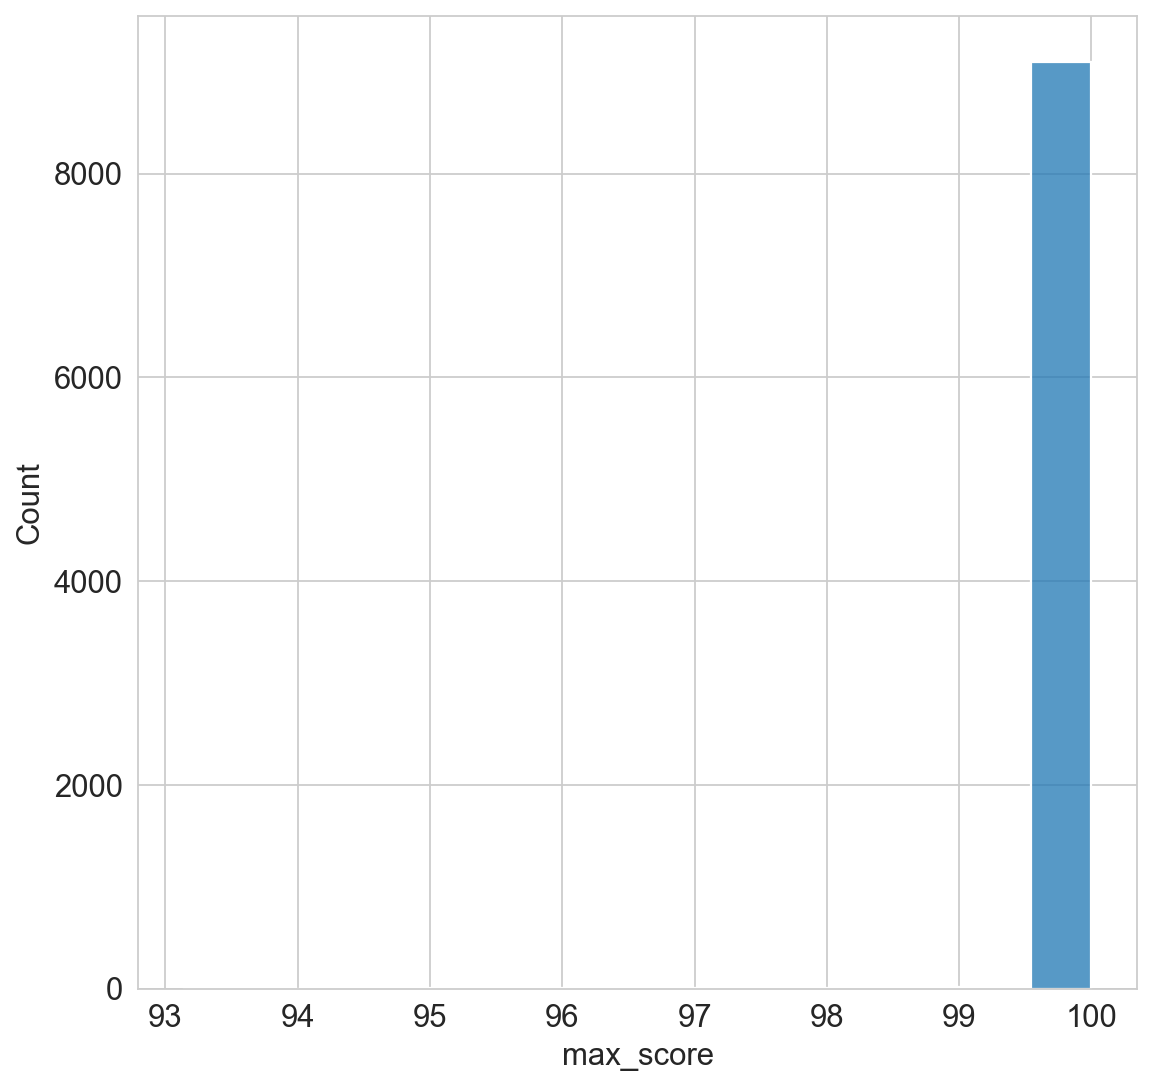

In [17]:
sb.histplot(adata.obs['max_score'])

## Remove Cross-Reactive TCRs

In [18]:
print(f'Before Cross-Reactive {len(adata)}')
adata = adata[(adata.obs[scores]>=92.5).sum(axis=1)==1]
print(f'After Cross-Reactive {len(adata)}')
adata.obs['max_epitope'].value_counts()

Before Cross-Reactive 9148
After Cross-Reactive 8982


NLVPMVATV_HLA-A*02:01     3620
GILGFVFTL_HLA-A*02:01     3482
TYGPVFMCL_HLA-A*24:02      556
KLPDDFTGCV_HLA-A*02:01     542
AVFDRKSDAK_HLA-A*11:01     360
AYAQKIFKI_HLA-A*24:02      242
TPRVTGGGAM_HLA-B*07:02     171
YVLDHLIVV_HLA-A*02:01        7
GLCTLVAML_HLA-A*02:01        2
Name: max_epitope, dtype: int64

## TCR clonotyping

In [19]:
## assign clonotypes, reduce to clonotype df

In [20]:
adata.obs[['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa']].value_counts()

IR_VJ_1_junction_aa  IR_VDJ_1_junction_aa
CARNTGNQFYF          CASSLGTGIGYYGYTF        4088
CAADDTNTGNQFYF       CASLYGGGGNEQFF           774
CALSEATSGSARQLTF     CASSYSARAYEQYF           541
CGTVGGSNYKLTF        CASSVDFRGNEQYF           485
CADYYGQNFVF          CASSFQGYTEAFF            390
                                             ... 
CAMNDFNKFYF          CSARVQSGQGQYF              1
CAMNDYKLSF           CASSFRDRGQETQYF            1
CAMREDQAGTALIF       CASSLVPLGTSGRTDTQYF        1
CAMREDTGGFKTIF       CASSFLDRTNSPLHF            1
CVYSGTYKYIF          CSAPSGGAIVNEQFF            1
Length: 234, dtype: int64

In [21]:
ir.pp.ir_dist(adata, metric='identity', sequence='aa')
ir.tl.define_clonotype_clusters(adata, metric='identity', receptor_arms='all', dual_ir='primary_only', 
                                sequence='aa', 
                                key_added='clone_id')

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
100%|██████████| 234/234 [00:00<00:00, 782.62it/s]

--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored clonal assignments in `adata.obs["clone_id"]`.


In [22]:
crossreactive_clones = adata.obs.groupby('clone_id')['max_epitope'].nunique()
crossreactive_clones = crossreactive_clones[crossreactive_clones>1].index.tolist()

print(f'With cross-reactive clones: {len(adata)}')
adata = adata[~adata.obs['clone_id'].isin(crossreactive_clones)]
print(f'WO cross-reactive clones: {len(adata)}')

With cross-reactive clones: 8982
WO cross-reactive clones: 2982


In [23]:
df_clones = adata.obs[[
       'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa',
       'IR_VJ_1_c_call', 'IR_VDJ_1_c_call',
       'IR_VJ_1_v_call', 'IR_VDJ_1_v_call',    
       'IR_VJ_1_d_call', 'IR_VDJ_1_d_call',
       'IR_VJ_1_j_call', 'IR_VDJ_1_j_call',
       'max_epitope', 'clone_id']].copy()
df_clones = df_clones.rename(columns={'max_epitope': 'epitope'})
df_clones.head(5)

,IR_VJ_1_junction_aa,IR_VDJ_1_junction_aa,IR_VJ_1_c_call,IR_VDJ_1_c_call,IR_VJ_1_v_call,IR_VDJ_1_v_call,IR_VJ_1_d_call,IR_VDJ_1_d_call,IR_VJ_1_j_call,IR_VDJ_1_j_call,epitope,clone_id
AAACGGGGTGCGCTTG-1-10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein,CAGNYGGSQGNLIF,CASSQRSTDTQYF,TRAC,TRBC2,TRAV25,TRBV19,NaN,NaN,TRAJ42,TRBJ2-3,GILGFVFTL_HLA-A*02:01,5
AAACGGGTCATTTGGG-1-10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein,CALSEATSGSARQLTF,CASSYSARAYEQYF,TRAC,TRBC2,TRAV19,TRBV6-6,NaN,NaN,TRAJ22,TRBJ2-7,KLPDDFTGCV_HLA-A*02:01,6
AAAGATGGTGCCTGTG-1-10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein,CAGAGGGSQGNLIF,CASSFRSTGELFF,TRAC,TRBC2,TRAV27,TRBV19,NaN,NaN,TRAJ42,TRBJ2-2,GILGFVFTL_HLA-A*02:01,8
AAAGCAAAGACAGGCT-1-10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein,CALSEATSGSARQLTF,CASSYSARAYEQYF,TRAC,TRBC2,TRAV19,TRBV6-6,NaN,NaN,TRAJ22,TRBJ2-7,KLPDDFTGCV_HLA-A*02:01,6
AAAGCAAAGCTGTTCA-1-10k_BEAM-T_Human_A0201_CMV_Flu_Covid_spikein,CALSEATSGSARQLTF,CASSYSARAYEQYF,TRAC,TRBC2,TRAV19,TRBV6-6,NaN,NaN,TRAJ22,TRBJ2-7,KLPDDFTGCV_HLA-A*02:01,6


In [24]:
print(f'Cells clones: {len(df_clones)}')
df_clones = df_clones.drop_duplicates(['clone_id'], keep='first')
df_clones = df_clones.reset_index(drop=True)
print(f'Clones: {len(df_clones)}')
df_clones['epitope'].value_counts()

Cells clones: 2982
Clones: 217


AVFDRKSDAK_HLA-A*11:01    109
GILGFVFTL_HLA-A*02:01      68
TYGPVFMCL_HLA-A*24:02      10
AYAQKIFKI_HLA-A*24:02       9
NLVPMVATV_HLA-A*02:01       7
YVLDHLIVV_HLA-A*02:01       6
TPRVTGGGAM_HLA-B*07:02      5
GLCTLVAML_HLA-A*02:01       2
KLPDDFTGCV_HLA-A*02:01      1
Name: epitope, dtype: int64

## Cluster via TCRdist

## Query to databases

## Save

In [25]:
# Save as pandas
df_clones.to_csv('../data/beam-t_clones.csv')